# Whisper Pretrained Evaluation on LibriSpeech & Fleurs

Whisper is a general-purpose speech recognition model. It is trained on a large dataset of diverse audio and is also a multi-task model that can perform multilingual speech recognition as well as speech translation and language identification.

Codes below adpated from [github repo](https://github.com/openai/whisper)

## Requirement
Python 3.9.9 and PyTorch 1.10.1

In [1]:
import os
print (os.environ['CONDA_DEFAULT_ENV'])

asr


In [1]:
pip install git+https://github.com/openai/whisper.git 

  Cloning https://github.com/openai/whisper.git to /private/var/folders/s3/cd0v0kp570g2sxvzwfq2vxdc0000gn/T/pip-req-build-rrrbxbzc
  Running command git clone -q https://github.com/openai/whisper.git /private/var/folders/s3/cd0v0kp570g2sxvzwfq2vxdc0000gn/T/pip-req-build-rrrbxbzc
  Resolved https://github.com/openai/whisper.git to commit 0b1ba3d46ebf7fe6f953acfd8cad62a4f851b49f
     |████████████████████████████████| 4.9 MB 2.0 MB/s eta 0:00:01
  Using cached filelock-3.8.0-py3-none-any.whl (10 kB)
     |████████████████████████████████| 163 kB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.6 MB 32.0 MB/s eta 0:00:01
  Created wheel for whisper: filename=whisper-1.0-py3-none-any.whl size=1175011 sha256=eb4ec63acdbdccebcccb823b53d13edcfc46f319e4056e032b4b338fb2644a71
  Stored in directory: /private/var/folders/s3/cd0v0kp570g2sxvzwfq2vxdc0000gn/T/pip-ephem-wheel-cache-zxq0mf0m/wheels/fe/03/29/e7919208d11b4ab32972cb448bb84a9a675d92cd52c9a48341
Successfully built whisper
No

**It also requires the command-line tool ffmpeg to be installed on your system, which is available from most package managers: (specifically for mac M1 arm64)**

In [3]:
# install homebrew
!/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"
# install rust
!curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh
# on MacOS using Homebrew (https://brew.sh/)
!brew install ffmpeg

Running `brew update --preinstall`...
Error: Cannot install under Rosetta 2 in ARM default prefix (/opt/homebrew)!
To rerun under ARM use:
    arch -arm64 brew install ...
To install under x86_64, install Homebrew into /usr/local.


# Base model testing

## English-only model

In [6]:
# test on recording made by sivan
import librosa
x, sr = librosa.load('audio.mp3')
print(x.shape)
print(sr)

/Users/sivanding/opt/miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(254957,)
22050


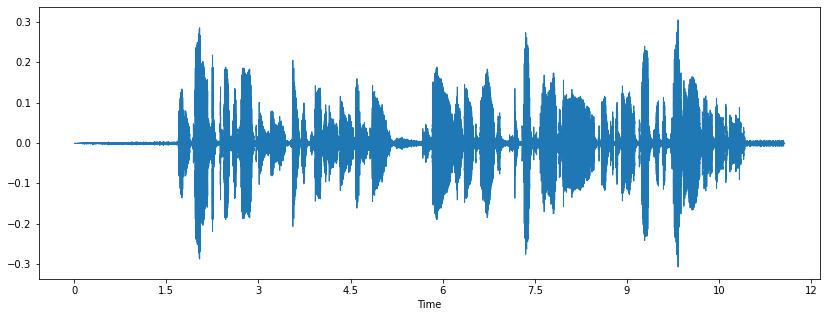

In [7]:
# viz
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

In [1]:
import IPython.display as ipd
ipd.Audio('audio.mp3')

In [2]:
import whisper

model = whisper.load_model("base")
result = model.transcribe("audio.mp3")
print(result["text"])

/Users/sivanding/opt/miniconda3/envs/asr/lib/python3.9/site-packages/whisper/transcribe.py:78: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 We study the capabilities of speech processing systems, trained simply to predict larger amounts of transcripts of audio on the internet.


In [6]:
import whisper

model = whisper.load_model("base")

# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("audio.mp3")
audio = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

# decode the audio
options = whisper.DecodingOptions(fp16 = False)
result = whisper.decode(model, mel, options)

# print the recognized text
print(result.text)

Detected language: en
We study the capabilities of speech processing systems, trained simply to predict larger amounts of transcripts of audio on the Internet.


### evaluation on LibriSpeech

In [11]:
! pip install jiwer

     |████████████████████████████████| 137 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 18.6 MB/s eta 0:00:01


In [13]:
# load dataset
# installing takes ~30 seconds
import os
import numpy as np

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import whisper
import torchaudio

from tqdm.notebook import tqdm


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class LibriSpeech(torch.utils.data.Dataset):
    """
    A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds.
    It will drop the last few seconds of a very small portion of the utterances.
    """
    def __init__(self, split="test-clean", device=DEVICE):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, _, _, _ = self.dataset[item]
        assert sample_rate == 16000
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel = whisper.log_mel_spectrogram(audio)
        
        return (mel, text)
    
dataset = LibriSpeech("test-clean")
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

In [14]:
# load base model and review
model = whisper.load_model("base.en")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

Model is English-only and has 71,825,408 parameters.


In [15]:
# predict without timestamps for short-form transcription
options = whisper.DecodingOptions(language="en", without_timestamps=True, fp16 = False)

In [ ]:
# base model + 2619 samples will take 12 hours....
hypotheses = []
references = []

for i, (mels, texts) in enumerate(tqdm(loader)):
    if i > 20:
        break
    results = model.decode(mels, options)
    hypotheses.extend([result.text for result in results])
    references.extend(texts)

In [8]:
# inspect on testing results
data = pd.DataFrame(dict(hypothesis=hypotheses, reference=references))
data

,hypothesis,reference
0,"He hoped there would be stew for dinner, turni...",HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...
1,"Stuffered into you, his belly counseled him.",STUFF IT INTO YOU HIS BELLY COUNSELLED HIM
2,After early nightfall the yellow lamps would l...,AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...
3,"Hello Bertie, any good in your mind?",HELLO BERTIE ANY GOOD IN YOUR MIND
4,Number 10. Fresh Nelly is waiting on you. Good...,NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...
...,...,...
2615,"Oh, to shoot my soul's full meaning into futur...",OH TO SHOOT MY SOUL'S FULL MEANING INTO FUTURE...
2616,"Then I, long tried by natural ills, received t...",THEN I LONG TRIED BY NATURAL ILLS RECEIVED THE...
2617,I love thee freely as men strive for right. I ...,I LOVE THEE FREELY AS MEN STRIVE FOR RIGHT I L...
2618,"I love thee with the passion put to use, in my...",I LOVE THEE WITH THE PASSION PUT TO USE IN MY ...


In [10]:
import jiwer
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()
data["hypothesis_clean"] = [normalizer(text) for text in data["hypothesis"]]
data["reference_clean"] = [normalizer(text) for text in data["reference"]]
data

,hypothesis,reference,hypothesis_clean,reference_clean
0,"He hoped there would be stew for dinner, turni...",HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...,he hoped there would be stew for dinner turnip...,he hoped there would be stew for dinner turnip...
1,"Stuffered into you, his belly counseled him.",STUFF IT INTO YOU HIS BELLY COUNSELLED HIM,stuffered into you his belly counseled him,stuff it into you his belly counseled him
2,After early nightfall the yellow lamps would l...,AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...,after early nightfall the yellow lamps would l...,after early nightfall the yellow lamps would l...
3,"Hello Bertie, any good in your mind?",HELLO BERTIE ANY GOOD IN YOUR MIND,hello bertie any good in your mind,hello bertie any good in your mind
4,Number 10. Fresh Nelly is waiting on you. Good...,NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...,number 10 fresh nelly is waiting on you good n...,number 10 fresh nelly is waiting on you good n...
...,...,...,...,...
2615,"Oh, to shoot my soul's full meaning into futur...",OH TO SHOOT MY SOUL'S FULL MEANING INTO FUTURE...,0 to shoot my soul is full meaning into future...,0 to shoot my soul is full meaning into future...
2616,"Then I, long tried by natural ills, received t...",THEN I LONG TRIED BY NATURAL ILLS RECEIVED THE...,then i long tried by natural ills received the...,then i long tried by natural ills received the...
2617,I love thee freely as men strive for right. I ...,I LOVE THEE FREELY AS MEN STRIVE FOR RIGHT I L...,i love thee freely as men strive for right i l...,i love thee freely as men strive for right i l...
2618,"I love thee with the passion put to use, in my...",I LOVE THEE WITH THE PASSION PUT TO USE IN MY ...,i love thee with the passion put to use in my ...,i love thee with the passion put to use in my ...


In [11]:
wer = jiwer.wer(list(data["reference_clean"]), list(data["hypothesis_clean"]))

print(f"WER: {wer * 100:.2f} %")

WER: 4.26 %


## Multilingual model

### Testing on Korean

In [3]:
import io
import os
import numpy as np

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import urllib
import tarfile
import whisper
import torchaudio

from scipy.io import wavfile
from tqdm.notebook import tqdm


pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [5]:
# download Korean from Fleurs
import ipywidgets as widgets

languages = {"af_za": "Afrikaans", "am_et": "Amharic", "ar_eg": "Arabic", "as_in": "Assamese", "az_az": "Azerbaijani", "be_by": "Belarusian", "bg_bg": "Bulgarian", "bn_in": "Bengali", "bs_ba": "Bosnian", "ca_es": "Catalan", "cmn_hans_cn": "Chinese", "cs_cz": "Czech", "cy_gb": "Welsh", "da_dk": "Danish", "de_de": "German", "el_gr": "Greek", "en_us": "English", "es_419": "Spanish", "et_ee": "Estonian", "fa_ir": "Persian", "fi_fi": "Finnish", "fil_ph": "Tagalog", "fr_fr": "French", "gl_es": "Galician", "gu_in": "Gujarati", "ha_ng": "Hausa", "he_il": "Hebrew", "hi_in": "Hindi", "hr_hr": "Croatian", "hu_hu": "Hungarian", "hy_am": "Armenian", "id_id": "Indonesian", "is_is": "Icelandic", "it_it": "Italian", "ja_jp": "Japanese", "jv_id": "Javanese", "ka_ge": "Georgian", "kk_kz": "Kazakh", "km_kh": "Khmer", "kn_in": "Kannada", "ko_kr": "Korean", "lb_lu": "Luxembourgish", "ln_cd": "Lingala", "lo_la": "Lao", "lt_lt": "Lithuanian", "lv_lv": "Latvian", "mi_nz": "Maori", "mk_mk": "Macedonian", "ml_in": "Malayalam", "mn_mn": "Mongolian", "mr_in": "Marathi", "ms_my": "Malay", "mt_mt": "Maltese", "my_mm": "Myanmar", "nb_no": "Norwegian", "ne_np": "Nepali", "nl_nl": "Dutch", "oc_fr": "Occitan", "pa_in": "Punjabi", "pl_pl": "Polish", "ps_af": "Pashto", "pt_br": "Portuguese", "ro_ro": "Romanian", "ru_ru": "Russian", "sd_in": "Sindhi", "sk_sk": "Slovak", "sl_si": "Slovenian", "sn_zw": "Shona", "so_so": "Somali", "sr_rs": "Serbian", "sv_se": "Swedish", "sw_ke": "Swahili", "ta_in": "Tamil", "te_in": "Telugu", "tg_tj": "Tajik", "th_th": "Thai", "tr_tr": "Turkish", "uk_ua": "Ukrainian", "ur_pk": "Urdu", "uz_uz": "Uzbek", "vi_vn": "Vietnamese", "yo_ng": "Yoruba"}
selection = widgets.Dropdown(
    options=[("Select language", None), ("----------", None)] + sorted([(f"{v} ({k})", k) for k, v in languages.items()]),
    value="ko_kr",
    description='Language:',
    disabled=False,
)

selection

Dropdown(description='Language:', index=39, options=(('Select language', None), ('----------', None), ('Afrika…

In [6]:
lang = selection.value
language = languages[lang]

assert lang is not None, "Please select a language"
print(f"Selected language: {language} ({lang})")

Selected language: Korean (ko_kr)


In [7]:
class Fleurs(torch.utils.data.Dataset):
    """
    A simple class to wrap Fleurs and subsample a portion of the dataset as needed.
    """
    def __init__(self, lang, split="test", subsample_rate=1, device=DEVICE):
        url = f"https://storage.googleapis.com/xtreme_translations/FLEURS102/{lang}.tar.gz"
        tar_path = os.path.expanduser(f"~/.cache/fleurs/{lang}.tgz")
        os.makedirs(os.path.dirname(tar_path), exist_ok=True)

        if not os.path.exists(tar_path):
            with urllib.request.urlopen(url) as source, open(tar_path, "wb") as output:
                with tqdm(total=int(source.info().get("Content-Length")), ncols=80, unit='iB', unit_scale=True, unit_divisor=1024) as loop:
                    while True:
                        buffer = source.read(8192)
                        if not buffer:
                            break

                        output.write(buffer)
                        loop.update(len(buffer))

        labels = {}
        all_audio = {}
        with tarfile.open(tar_path, "r:gz") as tar:
            for member in tar.getmembers():
                name = member.name
                if name.endswith(f"{split}.tsv"):
                    labels = pd.read_table(tar.extractfile(member), names=("id", "file_name", "raw_transcription", "transcription", "_", "num_samples", "gender"))

                if f"/{split}/" in name and name.endswith(".wav"):
                    audio_bytes = tar.extractfile(member).read()
                    all_audio[os.path.basename(name)] = wavfile.read(io.BytesIO(audio_bytes))[1]
                    

        self.labels = labels.to_dict("records")[::subsample_rate]
        self.all_audio = all_audio
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        record = self.labels[item]
        audio = torch.from_numpy(self.all_audio[record["file_name"]].copy())
        text = record["transcription"]
        
        return (audio, text)
    

In [8]:
# downloading ~2G for ~60 seconds
dataset = Fleurs(lang, subsample_rate=2)  # subsample 2% of the dataset for a quick demo

  0%|                                              | 0.00/1.65G [00:00<?, ?iB/s]

In [9]:
# still using base
model = whisper.load_model("base")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

Model is multilingual and has 71,825,920 parameters.


In [10]:
options = dict(language=language, beam_size=5, best_of=5, fp16 = False)
transcribe_options = dict(task="transcribe", **options)
translate_options = dict(task="translate", **options)

In [ ]:
# base model + 38 samples take 3 hours
references = []
transcriptions = []
translations = []

for audio, text in tqdm(dataset):
    transcription = model.transcribe(audio, **transcribe_options)["text"]
    translation = model.transcribe(audio, **translate_options)["text"]
    
    transcriptions.append(transcription)
    translations.append(translation)
    references.append(text)

In [10]:
data = pd.DataFrame(dict(reference=references, transcription=transcriptions, translation=translations))
data

,reference,transcription,translation
0,재입국 충격은 신혼 단계가 없기 때문에 문화 충격보다 빠르게 발생하며 더 오래 지속하고 더 극심할 수 있습니다,재입국 충격은 신혼 단계가 없기 때문에 문화 충격보다 빠르게 발생하며 더 오래 지속하고 더 극심할 수 있습니다.,"The reentry shock does not have a honeymoon stage, so it occurs faster than the cultural shock and can last longer and be more severe."
1,불행히도 운전자의 행동이 100% 확실하다고 예측할 수 없기 때문에 교통 흐름을 연구하기란 어렵다,불행히도 운전자의 행동이 100% 확실하다고 예측할 수 없기 때문에 교통 흐름을 연구하기란 어렵다.,"Unfortunately, it is difficult to study the flow of traffic because the driver's behavior is not 100% certain."
2,합금은 기본적으로 금속 두 개 이상의 혼합물이다 주기율표 상에 원소가 많이 있다는 것을 잊지 마라,합금은 기본적으로 금속 2개 이상의 혼합물이다. 주기율표상의 원소가 많이 있다는 것을 잊지 마라.,Don't forget that there are more than two metals in the alloy. Don't forget that there are more than two metals in the alloy.
3,홍콩 섬은 홍콩 영토에 홍콩이라는 이름을 부여한 곳이자 많은 관광객들이 주안점으로 여기는 곳이다,홍콩섬은 홍콩 영토에 홍콩이라는 이름을 부여한 곳이자 많은 관광객들이 주한점으로 여기는 곳이다.,"Hong Kong Island is a place named Hong Kong on Hong Kong territory, and it is the main destination of many tourists."
4,남자들을 단호히 거절하고 자신의 입장을 고수하는 것을 두려워하지 말라문화적 차이든 아니든 희롱은 간과될 수 없다!,남자들을 단호히 거절하고 자신의 입장을 고수하는 것을 두려워하지 말라. 문화적 차이든 아니든 희롱은 간과 될 수 없다.,"Do not be afraid to reject men and defend your position. Whether it is a cultural difference or not, it cannot be ignored."
5,좀 더 작은 섬의 대부분은 독립 국가이거나 프랑스와 관련이 있고 호화로운 비치 리조트로 알려져 있다,"좀 더 작은 섬의 대부분은 독립국가이거나 프랑스와 관련이 있고, 호화로운 비치 리조트로 알려져 있다.","Most of the smaller islands are independent or related to France, and are known as luxurious beach resorts."
6,사실 이게 존재한다는 사실을 아는 사람이 있다고 해도 찾는 것조차 쉽지 않습니다 일단 동굴 안에 들어가면 완전한 고립입니다,사실 이게 존재한다는 사실을 아는 사람이 있다고 해도 찾는 것조차 쉽지 않습니다. 일단 동그란에 들어가면 완전한 고립입니다.,"In fact, even if there are people who know that this exists, it is not easy to find it. Once you enter the cave, it is a complete isolation."
7,원단이 너무 뜨거워지지 않도록 주의하세요원단이 수축하거나 그을릴 수 있습니다,원단이 너무 뜨거워지지 않도록 주의하세요. 원단이 수축하거나 그을릴 수 있습니다.,Be careful not to heat the fabric too much. The fabric may shrink or get dirty.
8,도널드 트럼프 미국 대통령은 늦은 일요일 시간대에 대변인을 통해 발표한 성명에서 미군이 시리아에서 철수할 것이라고 발표했다,도널드 트럼프 미국 대통령은 늦은 일요일 시간대에 대변인을 통해 발표한 성명에서 미군이 시리아에서 철수할 것이라고 발표했다.,U.S. President Donald Trump announced on Sunday that the U.S. military would withdraw from Syria in his speech.
9,미국 체조 협회는 미국 올림픽 위원회의 서한을 지지하며 미국의 전 운동선수가 안전한 환경을 가질 수 있도록 돕는 올림픽 관계자의 절대적 필요성을 인정합니다,미국 체조협회는 미국 올림픽위원회의 서한을 지지하며 미국의 전 운동선수가 안전한 환경을 가질 수 있도록 돕는 올림픽 관계자의 절대적 필요성을 인정합니다.,The U.S. Sports Association supports the call of the U.S. Olympic Committee to help all athletes in the U.S. have a safe environment.


In [ ]:
# calculate WER

wer = jiwer.wer(list(data["reference_clean"]), list(data["hypothesis_clean"]))

print(f"WER: {wer * 100:.2f} %")

### Test on Hebrew

In [16]:
# download Hebrew from Fleurs
import ipywidgets as widgets

languages = {"af_za": "Afrikaans", "am_et": "Amharic", "ar_eg": "Arabic", "as_in": "Assamese", "az_az": "Azerbaijani", "be_by": "Belarusian", "bg_bg": "Bulgarian", "bn_in": "Bengali", "bs_ba": "Bosnian", "ca_es": "Catalan", "cmn_hans_cn": "Chinese", "cs_cz": "Czech", "cy_gb": "Welsh", "da_dk": "Danish", "de_de": "German", "el_gr": "Greek", "en_us": "English", "es_419": "Spanish", "et_ee": "Estonian", "fa_ir": "Persian", "fi_fi": "Finnish", "fil_ph": "Tagalog", "fr_fr": "French", "gl_es": "Galician", "gu_in": "Gujarati", "ha_ng": "Hausa", "he_il": "Hebrew", "hi_in": "Hindi", "hr_hr": "Croatian", "hu_hu": "Hungarian", "hy_am": "Armenian", "id_id": "Indonesian", "is_is": "Icelandic", "it_it": "Italian", "ja_jp": "Japanese", "jv_id": "Javanese", "ka_ge": "Georgian", "kk_kz": "Kazakh", "km_kh": "Khmer", "kn_in": "Kannada", "ko_kr": "Korean", "lb_lu": "Luxembourgish", "ln_cd": "Lingala", "lo_la": "Lao", "lt_lt": "Lithuanian", "lv_lv": "Latvian", "mi_nz": "Maori", "mk_mk": "Macedonian", "ml_in": "Malayalam", "mn_mn": "Mongolian", "mr_in": "Marathi", "ms_my": "Malay", "mt_mt": "Maltese", "my_mm": "Myanmar", "nb_no": "Norwegian", "ne_np": "Nepali", "nl_nl": "Dutch", "oc_fr": "Occitan", "pa_in": "Punjabi", "pl_pl": "Polish", "ps_af": "Pashto", "pt_br": "Portuguese", "ro_ro": "Romanian", "ru_ru": "Russian", "sd_in": "Sindhi", "sk_sk": "Slovak", "sl_si": "Slovenian", "sn_zw": "Shona", "so_so": "Somali", "sr_rs": "Serbian", "sv_se": "Swedish", "sw_ke": "Swahili", "ta_in": "Tamil", "te_in": "Telugu", "tg_tj": "Tajik", "th_th": "Thai", "tr_tr": "Turkish", "uk_ua": "Ukrainian", "ur_pk": "Urdu", "uz_uz": "Uzbek", "vi_vn": "Vietnamese", "yo_ng": "Yoruba"}
selection = widgets.Dropdown(
    options=[("Select language", None), ("----------", None)] + sorted([(f"{v} ({k})", k) for k, v in languages.items()]),
    value="cmn_hans_cn",
    description='Language:',
    disabled=False,
)

selection

Dropdown(description='Language:', index=13, options=(('Select language', None), ('----------', None), ('Afrika…

In [17]:
lang = selection.value
language = languages[lang]

assert lang is not None, "Please select a language"
print(f"Selected language: {language} ({lang})")

Selected language: Chinese (cmn_hans_cn)


In [ ]:
# downloading ~2G for ~60 seconds
dataset = Fleurs(lang, subsample_rate=0.5)  # subsample 2% of the dataset for a quick demo

In [10]:
options = dict(language=language, beam_size=5, best_of=5, fp16 = False)
transcribe_options = dict(task="transcribe", **options)
translate_options = dict(task="translate", **options)

In [ ]:
# base model + 38 samples take 3 hours
references = []
transcriptions = []
translations = []

for audio, text in tqdm(dataset):
    transcription = model.transcribe(audio, **transcribe_options)["text"]
    translation = model.transcribe(audio, **translate_options)["text"]
    
    transcriptions.append(transcription)
    translations.append(translation)
    references.append(text)

  0%|          | 0/191 [00:00<?, ?it/s]

In [10]:
data = pd.DataFrame(dict(reference=references, transcription=transcriptions, translation=translations))
data

,reference,transcription,translation
0,재입국 충격은 신혼 단계가 없기 때문에 문화 충격보다 빠르게 발생하며 더 오래 지속하고 더 극심할 수 있습니다,재입국 충격은 신혼 단계가 없기 때문에 문화 충격보다 빠르게 발생하며 더 오래 지속하고 더 극심할 수 있습니다.,"The reentry shock does not have a honeymoon stage, so it occurs faster than the cultural shock and can last longer and be more severe."
1,불행히도 운전자의 행동이 100% 확실하다고 예측할 수 없기 때문에 교통 흐름을 연구하기란 어렵다,불행히도 운전자의 행동이 100% 확실하다고 예측할 수 없기 때문에 교통 흐름을 연구하기란 어렵다.,"Unfortunately, it is difficult to study the flow of traffic because the driver's behavior is not 100% certain."
2,합금은 기본적으로 금속 두 개 이상의 혼합물이다 주기율표 상에 원소가 많이 있다는 것을 잊지 마라,합금은 기본적으로 금속 2개 이상의 혼합물이다. 주기율표상의 원소가 많이 있다는 것을 잊지 마라.,Don't forget that there are more than two metals in the alloy. Don't forget that there are more than two metals in the alloy.
3,홍콩 섬은 홍콩 영토에 홍콩이라는 이름을 부여한 곳이자 많은 관광객들이 주안점으로 여기는 곳이다,홍콩섬은 홍콩 영토에 홍콩이라는 이름을 부여한 곳이자 많은 관광객들이 주한점으로 여기는 곳이다.,"Hong Kong Island is a place named Hong Kong on Hong Kong territory, and it is the main destination of many tourists."
4,남자들을 단호히 거절하고 자신의 입장을 고수하는 것을 두려워하지 말라문화적 차이든 아니든 희롱은 간과될 수 없다!,남자들을 단호히 거절하고 자신의 입장을 고수하는 것을 두려워하지 말라. 문화적 차이든 아니든 희롱은 간과 될 수 없다.,"Do not be afraid to reject men and defend your position. Whether it is a cultural difference or not, it cannot be ignored."
5,좀 더 작은 섬의 대부분은 독립 국가이거나 프랑스와 관련이 있고 호화로운 비치 리조트로 알려져 있다,"좀 더 작은 섬의 대부분은 독립국가이거나 프랑스와 관련이 있고, 호화로운 비치 리조트로 알려져 있다.","Most of the smaller islands are independent or related to France, and are known as luxurious beach resorts."
6,사실 이게 존재한다는 사실을 아는 사람이 있다고 해도 찾는 것조차 쉽지 않습니다 일단 동굴 안에 들어가면 완전한 고립입니다,사실 이게 존재한다는 사실을 아는 사람이 있다고 해도 찾는 것조차 쉽지 않습니다. 일단 동그란에 들어가면 완전한 고립입니다.,"In fact, even if there are people who know that this exists, it is not easy to find it. Once you enter the cave, it is a complete isolation."
7,원단이 너무 뜨거워지지 않도록 주의하세요원단이 수축하거나 그을릴 수 있습니다,원단이 너무 뜨거워지지 않도록 주의하세요. 원단이 수축하거나 그을릴 수 있습니다.,Be careful not to heat the fabric too much. The fabric may shrink or get dirty.
8,도널드 트럼프 미국 대통령은 늦은 일요일 시간대에 대변인을 통해 발표한 성명에서 미군이 시리아에서 철수할 것이라고 발표했다,도널드 트럼프 미국 대통령은 늦은 일요일 시간대에 대변인을 통해 발표한 성명에서 미군이 시리아에서 철수할 것이라고 발표했다.,U.S. President Donald Trump announced on Sunday that the U.S. military would withdraw from Syria in his speech.
9,미국 체조 협회는 미국 올림픽 위원회의 서한을 지지하며 미국의 전 운동선수가 안전한 환경을 가질 수 있도록 돕는 올림픽 관계자의 절대적 필요성을 인정합니다,미국 체조협회는 미국 올림픽위원회의 서한을 지지하며 미국의 전 운동선수가 안전한 환경을 가질 수 있도록 돕는 올림픽 관계자의 절대적 필요성을 인정합니다.,The U.S. Sports Association supports the call of the U.S. Olympic Committee to help all athletes in the U.S. have a safe environment.


In [ ]:
# calculate WER

wer = jiwer.wer(list(data["reference_clean"]), list(data["hypothesis_clean"]))

print(f"WER: {wer * 100:.2f} %")